# **Import libraries**

In [91]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
%matplotlib inline

# **Load Dataset**

In [72]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abcsds/pokemon",
  'Pokemon.csv',
)

Using Colab cache for faster access to the 'pokemon' dataset.


# **Analyse Dataset**

There is no price column. I'll take correlation with Legendary.

In [3]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [73]:
df.drop(['#', 'Name'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Type 1      800 non-null    object
 1   Type 2      414 non-null    object
 2   Total       800 non-null    int64 
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(2)
memory usage: 63.4+ KB


In [74]:
df['Legendary'] = df['Legendary'].astype(int)

In [7]:
df.nunique()

,0
Type 1,18
Type 2,18
Total,200
HP,94
Attack,111
Defense,103
Sp. Atk,105
Sp. Def,92
Speed,108
Generation,6


In [75]:
dum_cols = ['Type 1', 'Type 2']

df = pd.get_dummies(df, columns=dum_cols)

In [54]:
df_corr = df.copy()

[]

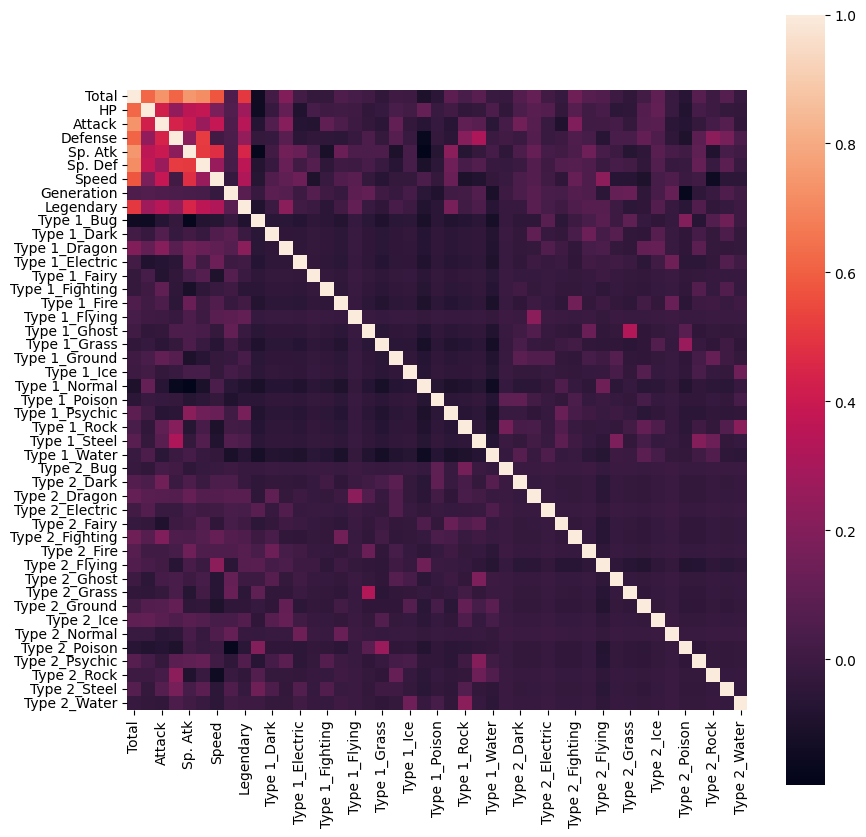

In [22]:
plt.figure(figsize=(10,10))

sns.heatmap(df_corr.corr(), square=True)

plt.plot()

In [27]:
pd.DataFrame(np.abs(df_corr.corr())).sort_values('Legendary', ascending=False)['Legendary'].head()

,Legendary
Legendary,1.000000
Total,0.501758
Sp. Atk,0.448907
Sp. Def,0.363937
Attack,0.345408


Judging by this top, I'll take Total and Sp. Atk.

In [28]:
df_temp = df[['Total', 'Sp. Atk']].copy()

# **Find Outliers**

In [38]:
outlier_models = [
    IsolationForest(random_state=42),
    OneClassSVM(),
    EllipticEnvelope(random_state=42),
    LocalOutlierFactor()
]

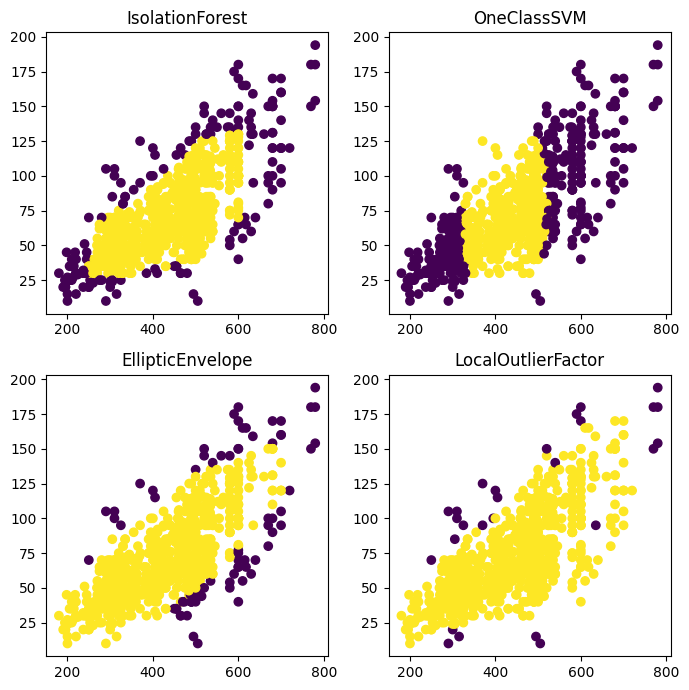

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

for i in range(len(outlier_models)):
    outliers = pd.Series(outlier_models[i].fit_predict(df_temp.values))
    ax = axs[i // 2][i % 2]
    ax.scatter(df_temp['Total'], df_temp['Sp. Atk'], c=outliers, cmap='viridis')
    ax.set_title(type(outlier_models[i]).__name__)

plt.tight_layout()
plt.show()

1. **Isolation Forest**

In the left bottom corner, even though it doesn't really look as an outlier, it is labeled so, because the distribution is skew.

2. **OneClassSVM**

Really bad, it does only count how many they are and how much do they lift the surface.

3. **Elliptic Envelope**

Looks pretty cool, even though some points are mislabeled due to the robust figure.

4. **LocalOutlierFactor**

The best, even though it might have mislabeled one point inside the main mass, as there is a small gap between it and other values.

# **Contamination**

I tried to scale data not to receive warnings, but it didn't work :(

In [58]:
cols_to_scale = ['Sp. Atk', 'Sp. Def', 'Total', 'Speed', 'Defense', 'Attack', 'HP']

df_corr[cols_to_scale] = StandardScaler().fit_transform(df_corr[cols_to_scale])

In [64]:
contaminations = [1e-2, 1e-1, 0.2, 0.4]
outlier_models = [
  IsolationForest,
  EllipticEnvelope,
  LocalOutlierFactor
]
results = []

for m in outlier_models:
    row = []
    for c in contaminations:
        model = m(contamination=c)
        preds = model.fit_predict(df_corr.drop('Legendary', axis=1).values)
        row.append((preds == -1).sum())
    results.append(row)

pd.DataFrame(results,
             index=[m.__name__ for m in outlier_models],
             columns=[f"cont={c}" for c in contaminations])

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


,cont=0.01,cont=0.1,cont=0.2,cont=0.4
IsolationForest,8,80,160,320
EllipticEnvelope,8,80,160,320
LocalOutlierFactor,8,80,160,320


The number of outliers is the same - no surprise, because the contamination parameter determines how many out of all samples will be labeled as outliers.

There is no OneClassSVM, as it doesn't have contamination at all.

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


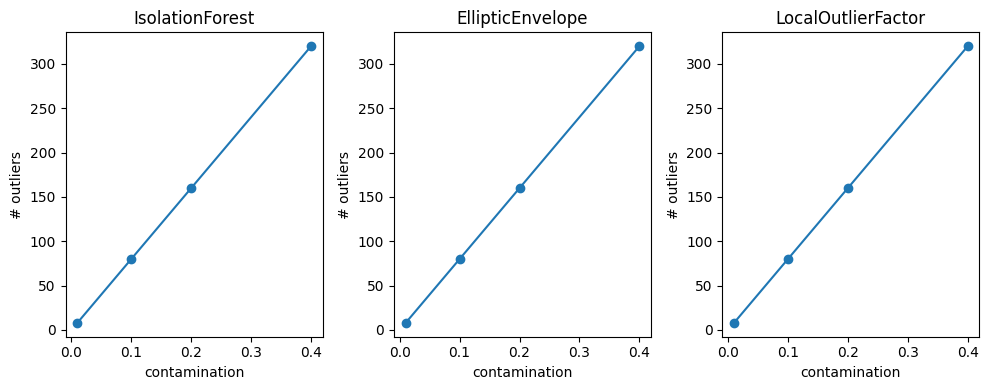

In [68]:
fig, axs = plt.subplots(ncols=3, figsize=(10,4))

for i, m in enumerate(outlier_models):
    n_out = []
    for c in contaminations:
        model = m(contamination=c)

        preds = model.fit_predict(df_corr.drop('Legendary', axis=1).values)
        n_out.append((preds == -1).sum())

    ax = axs[i]
    ax.plot(contaminations, n_out, marker='o')
    ax.set_title(m.__name__)
    ax.set_xlabel("contamination")
    ax.set_ylabel("# outliers")

plt.tight_layout()
plt.show()

As I mentioned earlier, doesn't matter which algorithm we use - either way contamination shows the number of outliers from the dataset to be found.

# **Split Dataset**

In [77]:
X = df.drop('Legendary', axis=1)
y = df['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's scale it

In [78]:
std_scaler = StandardScaler()

X_train[cols_to_scale] = std_scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = std_scaler.transform(X_test[cols_to_scale])

In [79]:
outlier_models = [
    IsolationForest(random_state=42),
    OneClassSVM(),
    EllipticEnvelope(random_state=42),
    LocalOutlierFactor()
]

## Subsets

In [82]:
X_trains, y_trains = [X_train], [y_train]

for m in outlier_models:
    preds = model.fit_predict(X_train)
    mask = preds == 1
    X_trains.append(X_train[mask])
    y_trains.append(y_train[mask])

## Train Models

Because I have binary values, instead of LinearRegression I'll use LogisticRegression and instead of KNN Regressor I'll use KNeighborsClassifier.

In [84]:
names = ['Initial', 'IsolationForest', 'OneClassSVM', 'EllipticEnvelope', 'LocalOutlierFactor']

In [94]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": lr.score(X_test, y_test),
        "KNNRClassifier": knn.score(X_test, y_test)
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.96250,0.94375
1,IsolationForest,0.94375,0.94375
2,OneClassSVM,0.94375,0.94375
3,EllipticEnvelope,0.94375,0.94375
4,LocalOutlierFactor,0.94375,0.94375


Looks too good. Let's analyse other metrics(f1_score).

In [95]:
df['Legendary'].sum()

np.int64(65)

The data is really skewed - only 65 Legendary Pokemons. So, f1_score will be more informative.

In [93]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": f1_score(y_test, lr.predict(X_test)),
        "KNNRClassifier": f1_score(y_test, knn.predict(X_test))
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.750000,0.571429
1,IsolationForest,0.689655,0.571429
2,OneClassSVM,0.689655,0.571429
3,EllipticEnvelope,0.689655,0.571429
4,LocalOutlierFactor,0.689655,0.571429


Now we see something more realistic.

As we see, all the algorithms have identified outliers which were meaningful, therefore the score dropped with all of them in the same measure from 0.75 to 0.69. The KNN classifier remained mostly unaffected at 0.57. This indicates that the outliers removed were meaningful for Logistic Regression, and their removal slightly decreased its predictive performance. For KNN, the outliers had little effect, likely because its predictions rely on local neighborhoods, so a few extreme points do not significantly change the decision boundaries.